In [1]:
import torch
from tqdm import tqdm

from models import SFCN
from utils.datasets import TorchDataset as TD

In [2]:
mode = 'val'
test_block = 'flat'

In [3]:
model = SFCN().to('cuda')
checkpoint = torch.load('checkpoints/PD-SFCN/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
block_dict = {'block1': model.block1,
              'block2': model.block2,
              'block3': model.block3,
              'block4': model.block4,
              'block5': model.block5,
              'flat':model.flat1}

In [5]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

model.eval()

activations = []
PD = []
age = []
sex = []
study = []
scanner_type = []
scanner_vendor = []


def hook_fn(module, input, module_output):
    activations.append(module_output.cpu().detach().numpy())


hook = block_dict[test_block].register_forward_hook(hook_fn)

td = TD(f'/data/Data/PD/{mode}')
test_loader = DataLoader(td, batch_size=32, shuffle=False)
# Collect activations
with torch.no_grad():
    for batch in tqdm(test_loader):
        _ = model(batch[0].to('cuda'))
        PD.extend(batch[1])
        sex.extend(batch[2])
        study.extend(batch[3])
        scanner_type.extend(batch[4])
    hook.remove()

100%|██████████| 6/6 [00:11<00:00,  1.92s/it]


In [6]:
activations = np.vstack(activations).reshape(td.__len__(), -1).squeeze()
PD = np.array(PD)
sex = np.array(sex)
study = np.array(study)
scanner_type = np.array(scanner_type)

In [7]:
import pickle

pca = PCA(n_components=16)
pca_result = pca.fit_transform(activations)

with open(f'/data/Data/PD/PCAs/{mode}_{test_block}.pkl', 'wb') as f:
    pickle.dump(pca, f)

In [8]:
import os

# pca_save_dir = f'/data/Data/PD/PCA_{test_block}_{mode}'
act_save_dir = f'/data/Data/PD/activations_{test_block}_{mode}'

# os.makedirs(pca_save_dir, exist_ok=True)
os.makedirs(act_save_dir, exist_ok=True)

for i in range(len(activations)):
    # ten = torch.tensor(np.hstack([study[i], sex[i], scanner_type[i], PD[i], pca_result[i]])).to(torch.float)
    # torch.save(ten, os.path.join(pca_save_dir, f'{i}'))
    
    ten2 = torch.tensor(np.hstack([study[i], sex[i], scanner_type[i], PD[i], activations[i]])).to(torch.float)
    torch.save(ten2, os.path.join(act_save_dir, f'{i}'))

In [9]:
def joint_plot(comps, col, name):
    fig = plt.figure(figsize=(4, 4))
    gs = fig.add_gridspec(4, 4, wspace=0, hspace=0)

    # Create the scatter plot and marginal axes
    ax_scatter = fig.add_subplot(gs[1:, :-1])
    ax_histx = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
    ax_histy = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

    sns.scatterplot(x=pca_result[:, comps[0]], y=pca_result[:, comps[1]], hue=col, palette='deep', alpha=0.6,
                    ax=ax_scatter, legend=False)
    cat = np.unique(col)
    for category, color in zip(cat, sns.color_palette()[:len(cat)]):
        mask = col == category
        sns.kdeplot(x=pca_result[mask, comps[0]], ax=ax_histx, color=color, fill=True, alpha=0.5, label=category)
        sns.kdeplot(y=pca_result[mask, comps[1]], ax=ax_histy, color=color, fill=True, alpha=0.5, label=category)

    ax_histx.set_ylabel('')
    ax_histx.set_title(name)
    ax_histy.set_xlabel('')

    ax_scatter.set_xlabel(f'PCA {comps[0]}')
    ax_scatter.set_ylabel(f'PCA {comps[1]}')

    ax_scatter.set_xticks([])
    ax_scatter.set_yticks([])

    ax_histx.grid(False)
    ax_histy.grid(False)

    ax_histx.set_xticks([])
    ax_histx.set_yticks([])

    ax_histy.set_xticks([])
    ax_histy.set_yticks([])

    plt.tight_layout()
    plt.show()

    return fig

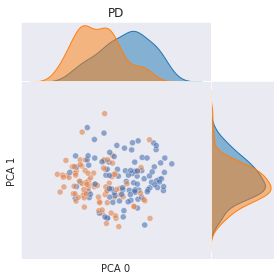

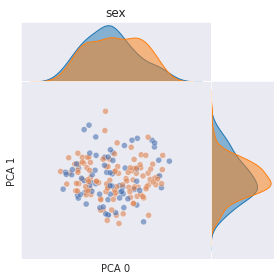

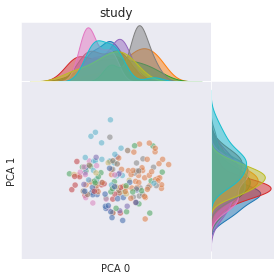

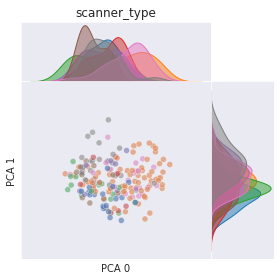

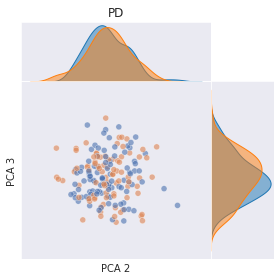

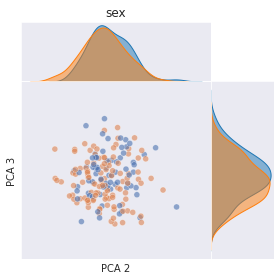

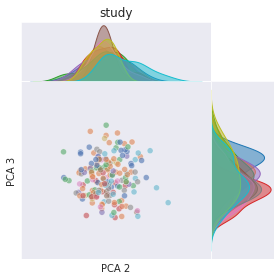

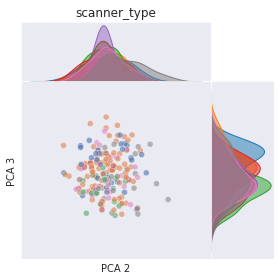

In [10]:
cols = [PD, sex, study, scanner_type]
names = ['PD', 'sex', 'study', 'scanner_type']
comps_tuple = ([0,1], [2,3])

for comps in comps_tuple:
    for c, n in zip(cols, names):
        joint_plot(comps, c, n).savefig(f'/data/Papers/MICCAI-biases/pca/{mode}_{test_block}_pca_{comps[0]}_{comps[1]}_{n}.pdf')